# MMA 823: Analytics for Financial Markets

## Load Libraries

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import date
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import yfinance as yf


## Data Organization 

In [2]:
# Load data from a CSV file
df = pd.read_excel("Sector_Info_Return_Ratio_Merged.xlsx")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84705 entries, 0 to 84704
Data columns (total 92 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   level_0              84705 non-null  int64         
 1   PERMNO_TICKER_LABEL  84705 non-null  object        
 2   public_date          83758 non-null  datetime64[ns]
 3   index                84705 non-null  int64         
 4   PERMNO               84705 non-null  int64         
 5   date                 84705 non-null  datetime64[ns]
 6   YEAR                 84705 non-null  int64         
 7   MONTH                84705 non-null  int64         
 8   SIC Industry Code    84705 non-null  int64         
 9   TICKER               84705 non-null  object        
 10  COMNAM               84705 non-null  object        
 11  Price Index          84705 non-null  float64       
 12  Past 1-Month Ret     84705 non-null  float64       
 13  Past 3-Month Ret     84705 non-

In [3]:
df.head()

,level_0,PERMNO_TICKER_LABEL,public_date,index,PERMNO,date,YEAR,MONTH,SIC Industry Code,TICKER,...,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb
0,0,10104-ORCL,2003-01-31,0,10104,2003-01-31,2003,1,7370,ORCL,...,5.178,8.674,1.537,1.619,2.102,0.122,0.014,0.0,-0.112,11.595
1,1,10104-ORCL,2003-02-28,1,10104,2003-02-28,2003,2,7370,ORCL,...,5.178,8.674,1.537,1.619,2.102,0.122,0.014,0.0,-0.112,11.468
2,2,10104-ORCL,2003-03-31,2,10104,2003-03-31,2003,3,7370,ORCL,...,5.178,8.674,1.537,1.619,2.102,0.122,0.014,0.0,-0.112,10.404
3,3,10104-ORCL,2003-04-30,3,10104,2003-04-30,2003,4,7370,ORCL,...,5.195,8.747,1.581,1.657,2.118,0.124,0.014,0.0,-0.115,10.816
4,4,10104-ORCL,2003-05-31,4,10104,2003-05-30,2003,5,7370,ORCL,...,5.195,8.747,1.581,1.657,2.118,0.124,0.014,0.0,-0.115,11.822


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84705 entries, 0 to 84704
Data columns (total 92 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   level_0              84705 non-null  int64         
 1   PERMNO_TICKER_LABEL  84705 non-null  object        
 2   public_date          83758 non-null  datetime64[ns]
 3   index                84705 non-null  int64         
 4   PERMNO               84705 non-null  int64         
 5   date                 84705 non-null  datetime64[ns]
 6   YEAR                 84705 non-null  int64         
 7   MONTH                84705 non-null  int64         
 8   SIC Industry Code    84705 non-null  int64         
 9   TICKER               84705 non-null  object        
 10  COMNAM               84705 non-null  object        
 11  Price Index          84705 non-null  float64       
 12  Past 1-Month Ret     84705 non-null  float64       
 13  Past 3-Month Ret     84705 non-

## Data Clean Up

In [5]:
#Drop Redundant Columns
drop_columns = ["level_0",'SIC Industry Code', "public_date", "adate", "qdate", "COMNAM", "PERMNO-YearMonth", "PERMNO_TICKER_LABEL", "PERMNO_DATE_LABEL", "index", "year", 'month','TICKER']
df_cleaned = df.drop(columns=drop_columns, errors="ignore")

#Drop Columns to avoid Data Leakage
features_to_remove = ['Forward 1-Month Ret', 'Forward 6-Month Ret']
df_cleaned = df_cleaned.drop(columns=features_to_remove, errors='ignore')

#Encode Sector Name
df_FE = pd.get_dummies(df_cleaned, columns=['Sector_Name'], prefix='Sector', drop_first=True, dtype=(int))
df_FE = df_FE.fillna(df_FE.mean())

#Fill Empty Rows with Mean
df_FE= df_FE.groupby('PERMNO').transform(lambda x: x.fillna(x.mean()))
df_FE['PERMNO'] = df_cleaned['PERMNO'].values

In [6]:
df_FE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84705 entries, 0 to 84704
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           84705 non-null  datetime64[ns]
 1   YEAR                           84705 non-null  int64         
 2   MONTH                          84705 non-null  int64         
 3   Price Index                    84705 non-null  float64       
 4   Past 1-Month Ret               84705 non-null  float64       
 5   Past 3-Month Ret               84705 non-null  float64       
 6   Past 6-Month Ret               84705 non-null  float64       
 7   Past 12-Month Ret              84705 non-null  float64       
 8   Forward 3-Month Ret            84705 non-null  float64       
 9   CAPEI                          84705 non-null  float64       
 10  bm                             84705 non-null  float64       
 11  evm            

## Feature Selection

In [7]:
selector = SelectKBest(f_regression,k=30)
X = df_FE.drop(columns=['Forward 3-Month Ret', 'date'], axis=1)
y = df_FE['Forward 3-Month Ret']
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))

df_FS = df_FE[selected_features].copy()
df_FS['date'] = df_FE['date'].values
df_FS['Forward 3-Month Ret'] = df_FE['Forward 3-Month Ret'].values
df_FS['PERMNO'] = df_FE['PERMNO'].values

Selected Features: ['YEAR', 'Price Index', 'Past 3-Month Ret', 'Past 12-Month Ret', 'bm', 'pe_exi', 'pcf', 'gpm', 'roa', 'roe', 'pretret_earnat', 'capital_ratio', 'cash_lt', 'rect_act', 'debt_ebitda', 'curr_debt', 'profit_lct', 'ocf_lct', 'debt_assets', 'debt_capital', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'pay_turn', 'sale_nwc', 'staff_sale', 'accrual', 'Sector_Consumer Staples', 'PERMNO']


## Test Train Split and Model Fitting

In [9]:
#Sort Data
df_final = df_FS.sort_values(by=['date', 'PERMNO'])

#Potential Test-Train split dates
split_dates = pd.to_datetime(['2015-01-01','2016-01-01','2017-01-01','2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01'])

#Dictionaries to store model results
xgb_results = {}

#Feature Importance
important_features_over_time = []

for split_date in split_dates:
  print(f'Split Date: {split_date}')
  #split data so that training data is before 'split_date' and test data is after 'split date'
  train_data = df_final[df_final['date'] < split_date]
  test_data = df_final[df_final['date'] >= split_date]

  #split predictors and target
  X_train = train_data.drop(columns=['Forward 3-Month Ret', 'date'], axis=1)
  y_train = train_data['Forward 3-Month Ret']

  X_test = test_data.drop(columns=['Forward 3-Month Ret', 'date'], axis=1)
  y_test = test_data['Forward 3-Month Ret']

  #scale features post splitting to avoid data leakage
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  #Train and evaluate random forest
  #Fit model
  xgb_model = XGBRegressor(random_state=24, n_jobs=-1)
  xgb_model.fit(X_train_scaled, y_train)

  # Get feature importances for all features
  importances = xgb_model.feature_importances_
  feature_importance_dict = dict(zip(X_train.columns, importances))

  # Store full importance vector for this split date
  important_features_over_time.append({
      'split_date': split_date.strftime('%Y-%m-%d'),
      **feature_importance_dict  # Unpack each feature and its importance
      })

  #Predict on Test Data
  xgb_predictions = xgb_model.predict(X_test_scaled)
  #Evaluate Performance
  xgb_rmse = mean_squared_error(y_test, xgb_predictions)
  xgb_mae = mean_absolute_error(y_test, xgb_predictions)

  #Print Performance Results
  print(f'XGB Regression RMSE: {xgb_rmse}')
  print(f'XGB Regression MAE: {xgb_mae}')
  xgb_results[split_date] = {'rmse': xgb_rmse, 'mae': xgb_mae}


Split Date: 2015-01-01 00:00:00
XGB Regression RMSE: 0.07410113890918443
XGB Regression MAE: 0.13860355914064626
Split Date: 2016-01-01 00:00:00
XGB Regression RMSE: 0.08498431356208819
XGB Regression MAE: 0.14614387808959695
Split Date: 2017-01-01 00:00:00
XGB Regression RMSE: 0.10388798030912973
XGB Regression MAE: 0.15135943451476094
Split Date: 2018-01-01 00:00:00
XGB Regression RMSE: 0.09789744154805677
XGB Regression MAE: 0.14695271047446667
Split Date: 2019-01-01 00:00:00
XGB Regression RMSE: 0.10320996861253948
XGB Regression MAE: 0.15073386528286536
Split Date: 2020-01-01 00:00:00
XGB Regression RMSE: 0.1324986249893027
XGB Regression MAE: 0.16688456835856574
Split Date: 2021-01-01 00:00:00
XGB Regression RMSE: 0.19289559656072827
XGB Regression MAE: 0.18693481804776932
Split Date: 2022-01-01 00:00:00
XGB Regression RMSE: 0.04527237918110687
XGB Regression MAE: 0.140418040245327
Split Date: 2023-01-01 00:00:00
XGB Regression RMSE: 0.028091646685747814
XGB Regression MAE: 0.109

## XGBoost Regression Results Summary

This analysis uses an XGBoost Regressor to predict forward 3-month stock returns (`Forward 3-Month Ret`) using historical features. The model is evaluated using a rolling train-test split, where the model is trained on data prior to a given `split_date` and tested on data following that date. This simulates real-world conditions where future data is not available during training.

---

## Evaluation Metrics

We use the following metrics to evaluate model performance:

- RMSE (Root Mean Squared Error)
  Measures the average squared difference between the predicted and actual returns. It penalizes larger errors more heavily.  
  _In this context, a lower RMSE indicates more accurate return forecasting with fewer large deviations._

- MAE (Mean Absolute Error)
  Measures the average absolute difference between predicted and actual returns.  
  _MAE tells us, on average, how far the model's prediction deviates from the actual 3-month return — making it easy to interpret in percentage terms._

---

##  Model Performance Over Time

| Split Date | RMSE | MAE | Comment |
|----------------|----------|---------|-------------|
| 2015-01-01     | 0.0741   | 0.1386  | Strong initial performance |
| 2016-01-01     | 0.0850   | 0.1461  | Slight increase in error |
| 2017-01-01     | 0.1039   | 0.1514  | Gradual decline in accuracy |
| 2018-01-01     | 0.0979   | 0.1470  | Small rebound in performance |
| 2019-01-01     | 0.1032   | 0.1507  | Returns to rising error trend |
| 2020-01-01     | 0.1325   | 0.1669  | Noticeable drop in performance (COVID volatility) |
| 2021-01-01     | 0.1929   | 0.1869  | Worst performance — likely due to market disruption |
| 2022-01-01     | 0.0453   | 0.1404  | Major improvement |
| 2023-01-01     | 0.0281   | 0.1095  | Best performance overall |

---

##  Key Takeaways

-  Strong early performance from 2015–2017, with manageable errors and stable predictions.

-  Performance degradation from 2018–2021, peaking in 2021 — likely due to unpredictable market regimes during and after the COVID-19 pandemic.

- Sharp recovery in 2022–2023, suggesting:
  - Better generalization as the training data grows over time
  - Return of more stable or predictable market conditions



## Feature Importance Analysis

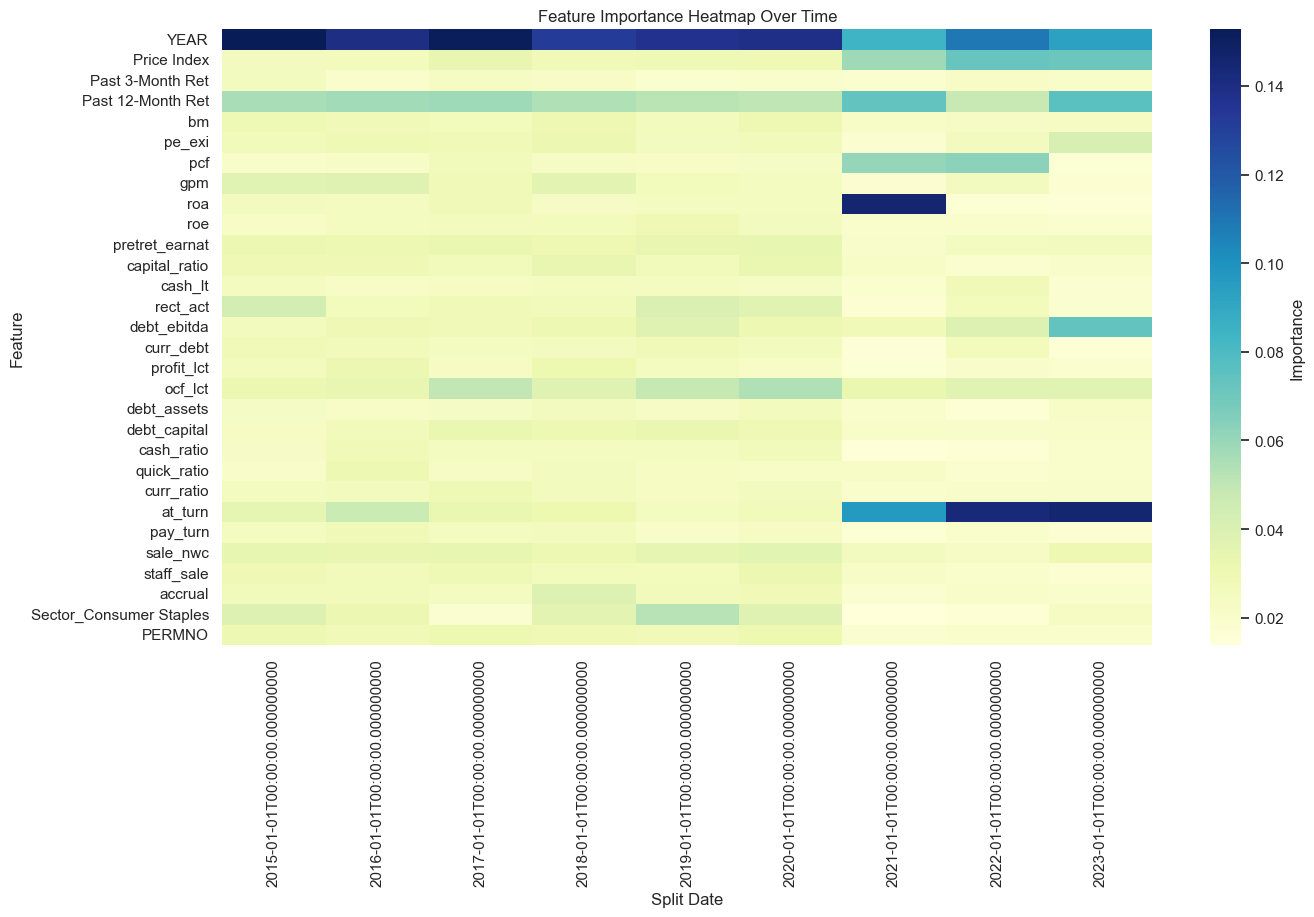

In [29]:
#convert feature importance over time dictionary to a pandas dataframe for easy handling
importance_df = pd.DataFrame(important_features_over_time)
importance_df['split_date'] = pd.to_datetime(importance_df['split_date'])

#Heat Map of Feature Importance Over Time
plt.figure(figsize=(15, 8))
sns.heatmap(importance_df.set_index('split_date').T, cmap='YlGnBu', cbar_kws={'label': 'Importance'})
plt.title('Feature Importance Heatmap Over Time')
plt.xlabel('Split Date')
plt.ylabel('Feature')
plt.show()

##  Feature Importance Heatmap Over Time (XGBoost)

This heatmap visualizes how the relative importance of each feature evolved across rolling time windows in the XGBoost regression model.

Each column represents a different training window split date, and each row is a feature used in the model. The color intensity indicates how important a feature was for predicting the forward 3-month return in that particular time period.

---

### Key Observations

- Price Index and Past Returns (3M, 12M) consistently held moderate importance, indicating strong momentum-related signals.
- In certain years (e.g., 2021–2022), features like:
  - `pretret_earnat` (pre-tax return on earnings)
  - `at_turn` (asset turnover)
  - `cash_lt` (cash over total liabilities)
  
  showed localized spikes in importance, suggesting the model adapted to changes in market behavior.
- Sector information and accrual-based metrics** had relatively low and stable influence throughout, indicating limited predictive power for near-term return.

---

### Interpretation

This time-evolving view of feature importance helps:
- Understand how the model’s decision process shifts across market regimes.
- Identify which features are consistently valuable and which ones are only useful in specific conditions.
- Guide feature selection and refinement for future models.



## Changes in Useful Features Over Time

Top 10 Features: ['YEAR', 'at_turn', 'Past 12-Month Ret', 'Price Index', 'ocf_lct', 'roa', 'debt_ebitda', 'sale_nwc', 'pcf', 'Sector_Consumer Staples']


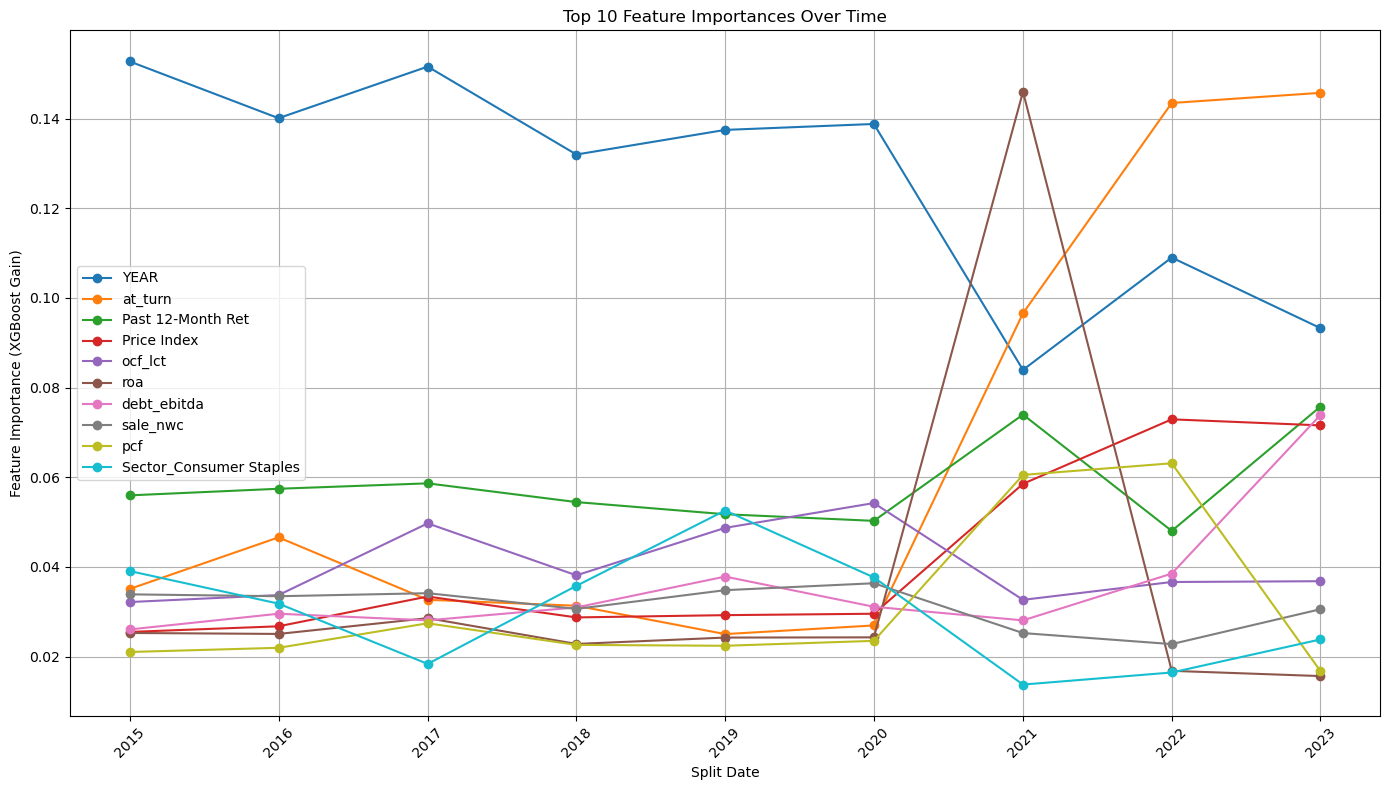

In [12]:
#Sum total importance for each feature
feature_totals = importance_df.drop(columns=['split_date']).sum().sort_values(ascending=False)

#Grab the top 10 features by overall cumulative importance
top_10_features = feature_totals.head(10).index.tolist()
print("Top 10 Features:", top_10_features)

plt.figure(figsize=(14, 8))

#Plot each top feature's importance over time
for feature in top_10_features:
    plt.plot(importance_df['split_date'], importance_df[feature], marker='o', label=feature)

plt.title('Top 10 Feature Importances Over Time')
plt.xlabel('Split Date')
plt.ylabel('Feature Importance (XGBoost Gain)')
plt.xticks(rotation=45)
plt.legend(loc='best', fontsize='medium')
plt.grid(True)
plt.tight_layout()
plt.show()

## Top 10 Feature Importances Over Time (XGBoost)

This line chart tracks how the importance of the top 10 features (measured using XGBoost Gain) evolved across rolling time splits from 2015 to 2023.

Each line represents a feature, and each point shows its relative importance at a given training window. The features were selected based on their cumulative importance over all splits.

---

### Key Insights

- `YEAR` had the highest and most consistent importance early on, but declined post-2020. This may suggest it acted as a proxy for time-related effects early in the model.
- `at_turn` (asset turnover) and `Past 12-Month Ret` became increasingly important in later years, particularly after 2020 — highlighting momentum and efficiency factors in more recent periods.
- `Price Index` and `ocf_lct` (operating cash flow to liabilities) held steady mid-level importance, reflecting the continued value of liquidity and valuation-based metrics.
- `roa` (return on assets) spiked sharply in 2021, possibly capturing profitability effects during post-COVID recovery.
- Features like `debt_ebitda`, `sale_nwc`, and `Sector_Consumer Staples` showed moderate but fluctuating contributions, suggesting selective influence under changing market regimes.

---

### Why This Matters

Understanding how feature importance shifts over time helps:
- Reveal which features are consistently predictive.
- Detect regime changes, where new signals become more valuable.
- Improve model interpretability and guide dynamic feature engineering for future iterations.



## Statistical Significance of Results

In [13]:
#Print Final Results
results_df = pd.DataFrame.from_dict(xgb_results, orient='index').reset_index()
results_df.columns = ['Split Date', 'RMSE', 'MAE']

#Sort by RMSE or MAE
results_df = results_df.sort_values(by='RMSE').reset_index(drop=True)

print(results_df)

  Split Date      RMSE       MAE
0 2023-01-01  0.028092  0.109487
1 2022-01-01  0.045272  0.140418
2 2015-01-01  0.074101  0.138604
3 2016-01-01  0.084984  0.146144
4 2018-01-01  0.097897  0.146953
5 2019-01-01  0.103210  0.150734
6 2017-01-01  0.103888  0.151359
7 2020-01-01  0.132499  0.166885
8 2021-01-01  0.192896  0.186935


##  Sorted XGBoost Performance by Split Date

Above is the model's prediction error ranked by performance (best to worst) based on RMSE and MAE.

2023 and 2022 had the lowest prediction errors, confirming the model’s strongest performance in recent periods.  
2021 had the highest error, reflecting challenges during a volatile market regime.


## ML Model Execution

In [ ]:
# Load dataset
data_path = "Sector_Info_Return_Ratio_Merged.xlsx"  
df_sector = pd.read_excel(data_path,)

# Convert date column to datetime format
df_sector['date'] = pd.to_datetime(df_sector['date'])

# Apply log transformation
df_sector['log_Past_3M_Ret'] = np.log1p(df_sector['Past 3-Month Ret'])
df_sector['log_Forward_3M_Ret'] = np.log1p(df_sector['Forward 3-Month Ret'])

# Define Features
features = ['Past 1-Month Ret', 'Past 3-Month Ret', 'Past 6-Month Ret', 'Past 12-Month Ret','CAPEI', 'bm', 'pe_op_basic', 'ps',
        'roa', 'roe', 'gpm','debt_invcap', 'capital_ratio','cash_ratio', 'quick_ratio', 'curr_ratio','inv_turn', 'at_turn', 'YEAR',
          'ocf_lct', 'debt_ebitda', 'Price Index', 'rect_act', 'sale_nwc', 'pretret_earnat']

# Function to get the closest available date before or equal to target date
def get_closest_date(df, target_date):
    available_dates = df['date'].unique()
    available_dates = pd.to_datetime(available_dates)
    target_date = pd.to_datetime(target_date)
    
    closest_date = available_dates[available_dates <= target_date].max()  
    return closest_date

# Define Model Training & Prediction Function
def train_and_predict(df, train_end):
    closest_train_end = get_closest_date(df, train_end)
    if pd.isna(closest_train_end):
        print(f"Skipping {train_end} due to insufficient data.")
        return None
    
    train_data = df[df['date'] < closest_train_end].copy()
    test_data = df[df['date'] == closest_train_end].copy()
    target = 'log_Forward_3M_Ret'

    if train_data.empty or test_data.empty:
        print(f"Skipping {train_end} due to insufficient data.")
        return None

    X_train, y_train = train_data[features], train_data[target]
    X_test = test_data[features]

    # Handle missing values
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train XGBoost Model
    model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5,
                         random_state=42, early_stopping_rounds=10)
    model.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train)], verbose=False)

    test_data['Predicted_log_Forward_3M_Ret'] = model.predict(X_test_scaled)
    test_data['Predicted_Forward_3M_Ret'] = np.expm1(test_data['Predicted_log_Forward_3M_Ret'])
    return test_data[['PERMNO', 'TICKER', 'COMNAM', 'date', 'Predicted_Forward_3M_Ret']]

# Define target prediction dates
target_dates = ["2021-01-01", "2022-01-01", "2023-01-01"]
predictions = {}

# Generate predictions for each target date
for target_date in target_dates:
    print(f"Processing predictions for {target_date}...")
    pred = train_and_predict(df_sector, target_date)
    
    if pred is not None:
        predictions[target_date] = pred

# Save results to an Excel file with separate sheets for each year
output_path = "Predicted_Stock_Returns.xlsx"
with pd.ExcelWriter(output_path) as writer:
    for date, df_result in predictions.items():
        df_result.to_excel(writer, sheet_name=f"{date}", index=False)

# Provide download link for the Excel file
output_path

Processing predictions for 2021-01-01...
Processing predictions for 2022-01-01...
Processing predictions for 2023-01-01...


'Predicted_Stock_Returns.xlsx'

## Compare Predicted vs. Actual Performance

In [15]:
# Reload the actual stock returns dataset
actual_data_path = "Sector_Info_Return_Ratio_Merged.xlsx"
df_actual = pd.read_excel(actual_data_path, usecols=["PERMNO", "date", "Forward 3-Month Ret"], engine='openpyxl')

# Convert date column to datetime format
df_actual['date'] = pd.to_datetime(df_actual['date'])

# Function to get the closest available date before or equal to the target date
def get_closest_date(df, permno, target_date):
    available_dates = df[df["PERMNO"] == permno]["date"].dropna().unique()
    available_dates = pd.to_datetime(available_dates)
    target_date = pd.to_datetime(target_date)

    closest_date = available_dates[available_dates <= target_date].max()  # Get latest available date
    return closest_date

# Load the predicted stock returns dataset sheet by sheet
predicted_data_path = "Predicted_Stock_Returns.xlsx"
predicted_sheets = pd.ExcelFile(predicted_data_path).sheet_names

# Dictionary to store comparison results
comparison_results = {}

# Process each sheet efficiently
for sheet_name in predicted_sheets:
    print(f"Processing {sheet_name}...")

    # Load only relevant columns from the predicted dataset
    df_pred = pd.read_excel(predicted_data_path, sheet_name=sheet_name, usecols=['PERMNO', 'TICKER', 'COMNAM', 'date',"Predicted_Forward_3M_Ret"], engine='openpyxl')

    # Convert date column to datetime format
    df_pred['date'] = pd.to_datetime(df_pred['date'])

    # Ensure we get the closest available date if the exact match isn't found
    actual_returns = []
    closest_dates_used = []  # Store closest dates for debugging

    for index, row in df_pred.iterrows():
        closest_date = get_closest_date(df_actual, row["PERMNO"], row["date"])
        
        if pd.isna(closest_date):  # If there's no available date, skip the record
            actual_returns.append(np.nan)
            closest_dates_used.append(None)
        else:
            actual_return = df_actual[(df_actual["PERMNO"] == row["PERMNO"]) & (df_actual["date"] == closest_date)]["Forward 3-Month Ret"]
            actual_returns.append(actual_return.values[0] if not actual_return.empty else np.nan)
            closest_dates_used.append(closest_date)  # Store closest date used

    # Assign actual returns and closest date match
    df_pred["Forward_3M_Ret_Actual"] = actual_returns
    df_pred["Closest_Date_Used"] = closest_dates_used

    # Remove any rows with missing actual returns (no zeros should appear)
    df_pred = df_pred.dropna(subset=["Forward_3M_Ret_Actual"])

    # Compute the prediction error
    df_pred['Prediction_Error'] = df_pred['Predicted_Forward_3M_Ret'] - df_pred['Forward_3M_Ret_Actual']

    # Store results
    comparison_results[sheet_name] = df_pred

# Save results to an optimized Excel file with separate sheets for each period
output_comparison_path = "Actual_vs_Predicted_Comparison.xlsx"
with pd.ExcelWriter(output_comparison_path) as writer:
    for sheet_name, df_result in comparison_results.items():
        df_result.to_excel(writer, sheet_name=sheet_name, index=False)

# Provide the download link for the final comparison file
output_comparison_path


Processing 2021-01-01...
Processing 2022-01-01...
Processing 2023-01-01...


'Actual_vs_Predicted_Comparison.xlsx'

## Predicted vs. Actual Performance Visuals & Analysis

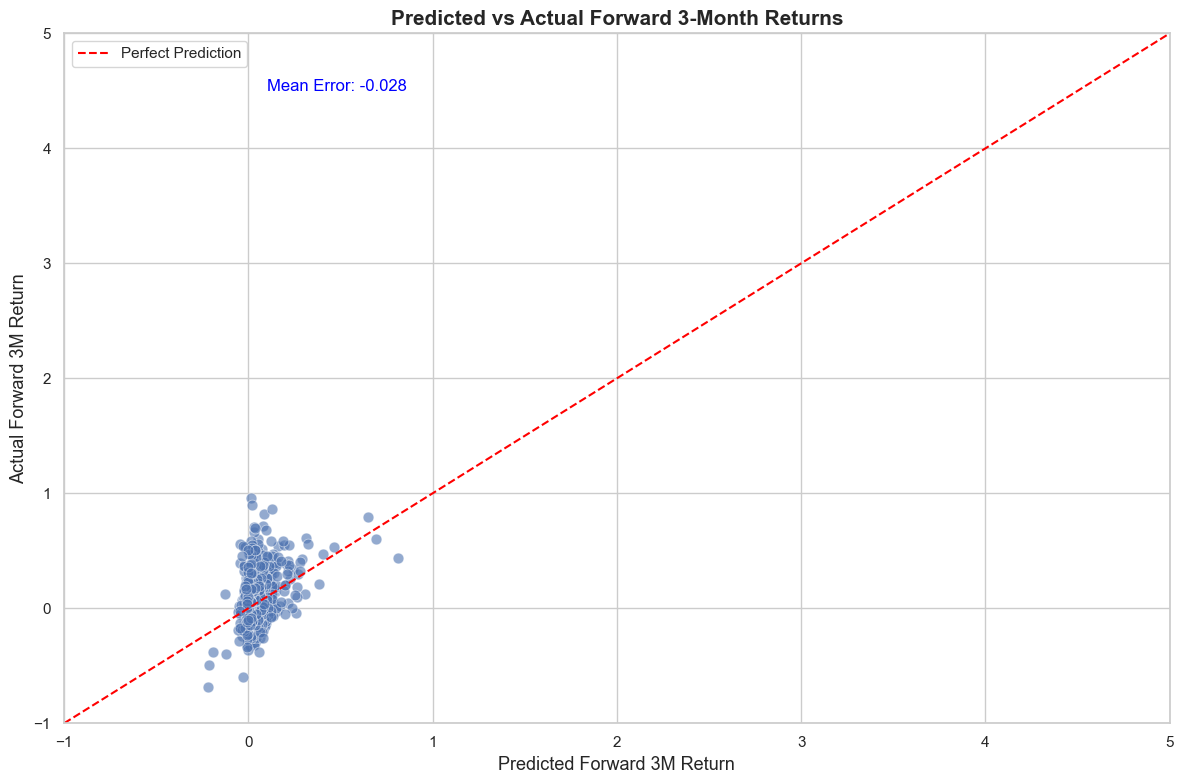

c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


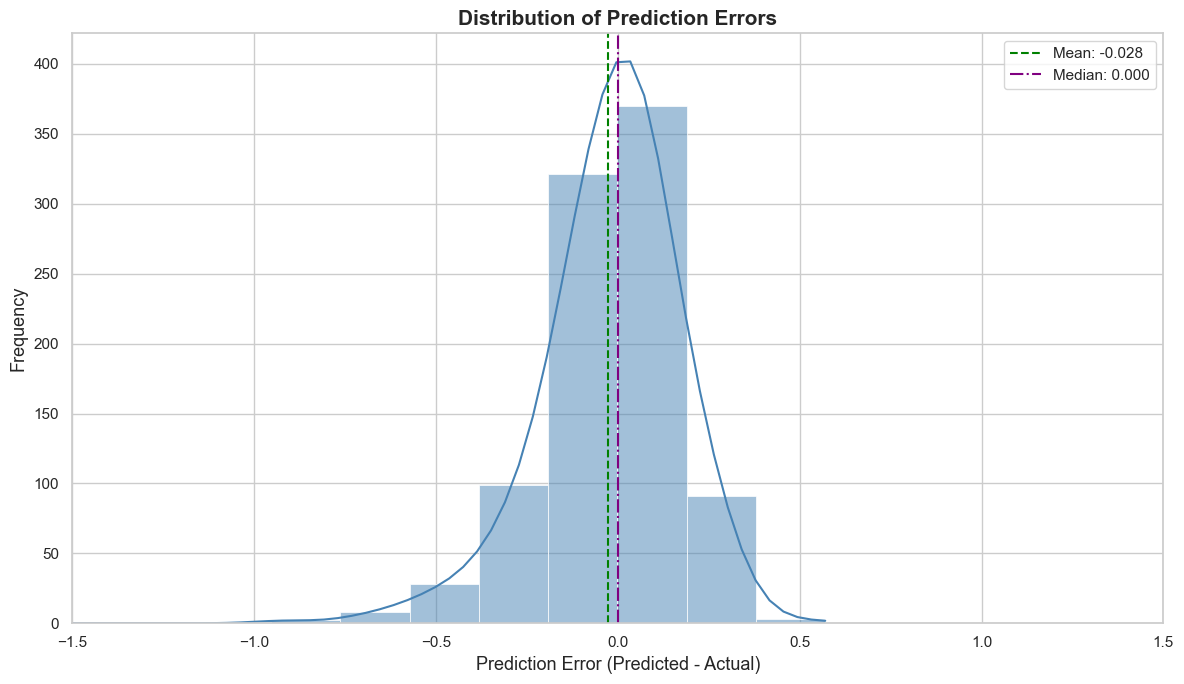

c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


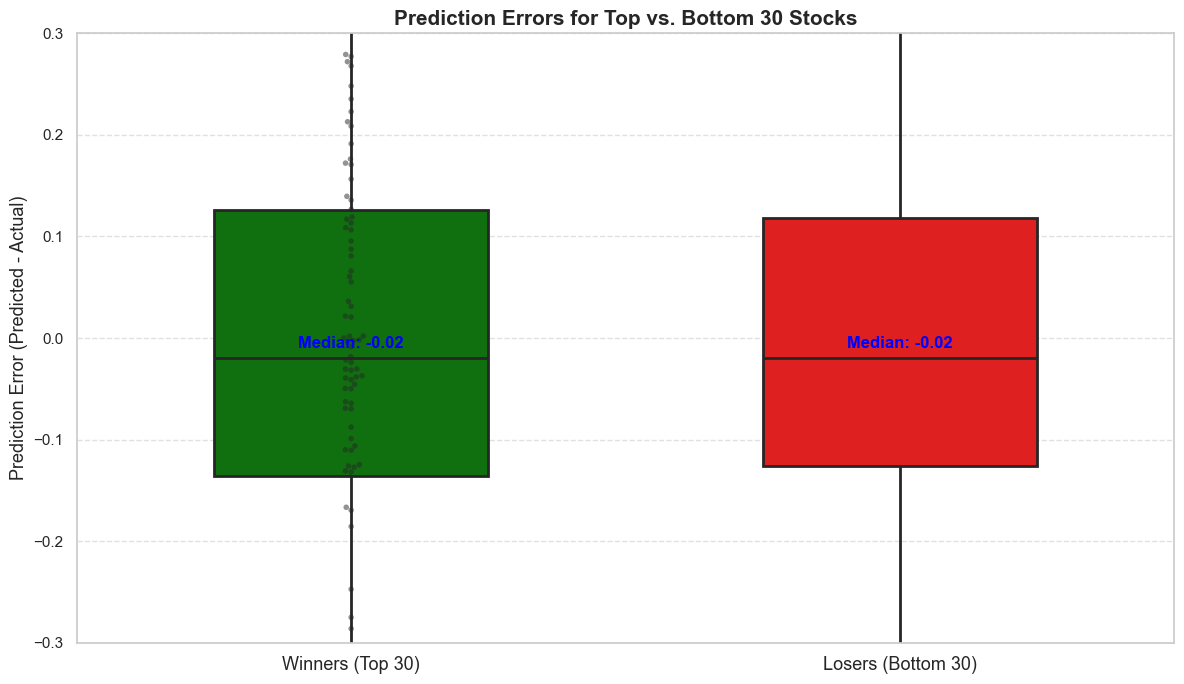

Winners Summary:
              PERMNO                 date  Predicted_Forward_3M_Ret  \
count     90.000000                   90                 90.000000   
mean   60404.633333  2021-12-30 16:00:00                  0.166217   
min    10890.000000  2020-12-31 00:00:00                  0.017245   
25%    36672.750000  2020-12-31 00:00:00                  0.054213   
50%    71031.500000  2021-12-31 00:00:00                  0.082010   
75%    84578.750000  2022-12-30 00:00:00                  0.218150   
max    91926.000000  2022-12-30 00:00:00                  2.026359   
std    26615.945350                  NaN                  0.247796   

       Forward_3M_Ret_Actual    Closest_Date_Used  Prediction_Error  \
count              90.000000                   90         90.000000   
mean                0.277860  2021-12-30 16:00:00         -0.111643   
min                -0.257541  2020-12-31 00:00:00         -7.049006   
25%                 0.001269  2020-12-31 00:00:00         -0.135970

In [16]:
# Reload the Actual vs Predicted Comparison dataset
comparison_data_path = "Actual_vs_Predicted_Comparison.xlsx"
comparison_sheets = pd.ExcelFile(comparison_data_path).sheet_names

# Dictionary to store data from all sheets
comparison_data = {}

# Load each sheet
for sheet_name in comparison_sheets:
    comparison_data[sheet_name] = pd.read_excel(comparison_data_path, sheet_name=sheet_name, engine='openpyxl')

# Concatenate all sheets into a single DataFrame for analysis
df_comparison = pd.concat(comparison_data.values(), ignore_index=True)

# Compute overall error statistics
df_comparison["Absolute_Error"] = abs(df_comparison["Prediction_Error"])
df_comparison["Squared_Error"] = df_comparison["Prediction_Error"] ** 2

# Identify Winners (Top 30 stocks) and Losers (Bottom 30 stocks) per period
winners = df_comparison.groupby("date").apply(lambda x: x.nlargest(30, "Predicted_Forward_3M_Ret")).reset_index(drop=True)
losers = df_comparison.groupby("date").apply(lambda x: x.nsmallest(30, "Predicted_Forward_3M_Ret")).reset_index(drop=True)

# Compute summary statistics for winners and losers
winners_summary = winners.describe()
losers_summary = losers.describe()

## Prediction vs Actual Scatter Plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Scatter plot
sns.scatterplot(
    data=df_comparison,
    x="Predicted_Forward_3M_Ret",
    y="Forward_3M_Ret_Actual",
    alpha=0.6,
    s=60,
    edgecolor="w",
    linewidth=0.5
)

# Perfect prediction line
plt.plot([-1, 5], [-1, 5], linestyle="--", color="red", label="Perfect Prediction")

# Highlight mean prediction error
error_mean = df_comparison["Prediction_Error"].mean()
plt.text(0.1, 4.5, f"Mean Error: {error_mean:.3f}", fontsize=12, color='blue')

# Aesthetics
plt.xlabel("Predicted Forward 3M Return", fontsize=13)
plt.ylabel("Actual Forward 3M Return", fontsize=13)
plt.title("Predicted vs Actual Forward 3-Month Returns", fontsize=15, fontweight='bold')
plt.xlim(-1, 5)
plt.ylim(-1, 5)
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


## Error Distribution Histogram
plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")

# Histogram + KDE
sns.histplot(df_comparison["Prediction_Error"], bins=40, kde=True, color="steelblue", edgecolor="white", linewidth=0.5)

# Add vertical lines for mean and median
mean_error = df_comparison["Prediction_Error"].mean()
median_error = df_comparison["Prediction_Error"].median()
plt.axvline(mean_error, color='green', linestyle='--', label=f"Mean: {mean_error:.3f}")
plt.axvline(median_error, color='purple', linestyle='-.', label=f"Median: {median_error:.3f}")

# Labels
plt.xlabel("Prediction Error (Predicted - Actual)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title("Distribution of Prediction Errors", fontsize=15, fontweight='bold')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Setup figure
plt.figure(figsize=(12, 7))

# Main boxplot
ax = sns.boxplot(
    data=[winners["Prediction_Error"], losers["Prediction_Error"]],
    palette=["green", "red"],
    width=0.5,
    fliersize=3,
    linewidth=2
)

# Overlay actual data points using swarmplot for visibility
sns.swarmplot(
    data=[winners["Prediction_Error"], losers["Prediction_Error"]],
    color='black',
    size=4,
    alpha=0.5
)

# Set x-axis labels
ax.set_xticklabels(["Winners (Top 30)", "Losers (Bottom 30)"], fontsize=13)

# Add titles and labels
plt.ylabel("Prediction Error (Predicted - Actual)", fontsize=13)
plt.title("Prediction Errors for Top vs. Bottom 30 Stocks", fontsize=15, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Set tighter zoom
plt.ylim(-0.3, 0.3)  # Adjust this if you want to zoom more or less

# Annotate median values
medians = [group["Prediction_Error"].median() for group in [winners, losers]]
for i, median in enumerate(medians):
    ax.text(i, median + 0.01, f"Median: {median:.2f}", 
            horizontalalignment='center', color='blue', weight='bold')

plt.tight_layout()
plt.show()

## Display Summary Stats
print("Winners Summary:\n", winners_summary)
print("\nLosers Summary:\n", losers_summary)


##  Model Diagnostics: Predicted vs Actual & Error Distribution

### 1.  Predicted vs Actual Scatter Plot
The scatter plot compares the model’s predicted 3-month returns against actual outcomes.  
- Most points cluster near the red dashed line (perfect prediction).
- A slight underprediction bias is visible, supported by the mean error of -0.028.

---

### 2. Distribution of Prediction Errors
This histogram shows the spread of errors (Predicted – Actual).
- The distribution is roughly symmetric and centered near zero.
- Mean Error = -0.028 indicating minimal bias overall.

---

### 3. Box Plot: Top vs Bottom 30 Stocks
Box plots compare prediction errors for the Top 30 predicted winners and Bottom 30 predicted losers.
- Both groups show similar median error (-0.02).
- Model errors are reasonably consistent across high and low return portfolios.

---

Overall, these diagnostics indicate reasonable predictive accuracy, slight underestimation bias, and balanced performance across top and bottom-ranked predictions.


c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


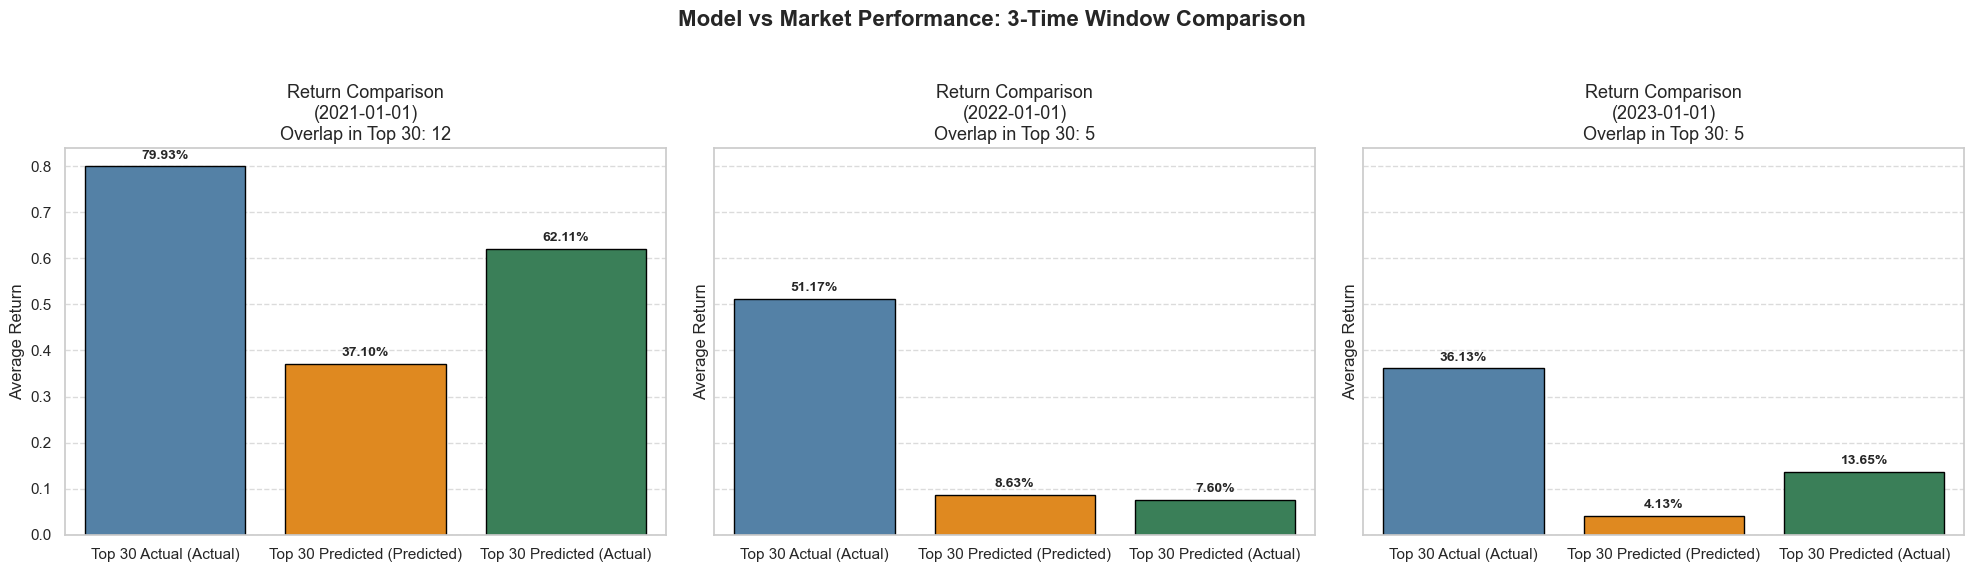

In [ ]:
# Load the Excel file
file_path = "Actual_vs_Predicted_Comparison.xlsx"
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

# Store results for plotting
plot_data = []

# Process each sheet (assumed to be different time splits)
for sheet in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)

    # Bar 1: Top 30 by actual return
    top30_actual = df.nlargest(30, 'Forward_3M_Ret_Actual')
    bar1_mean = top30_actual['Forward_3M_Ret_Actual'].mean()

    # Bar 2: Top 30 by predicted return
    top30_predicted = df.nlargest(30, 'Predicted_Forward_3M_Ret')
    bar2_mean = top30_predicted['Predicted_Forward_3M_Ret'].mean()

    # Bar 3: Actual returns of top 30 predicted
    bar3_mean = top30_predicted['Forward_3M_Ret_Actual'].mean()

    # Calculate overlap between predicted and actual top 30
    overlap = len(set(top30_predicted['TICKER']).intersection(set(top30_actual['TICKER'])))

    plot_data.append({
        'Time Period': sheet,
        'Bar Labels': ['Top 30 Actual (Actual)', 'Top 30 Predicted (Predicted)', 'Top 30 Predicted (Actual)'],
        'Means': [bar1_mean, bar2_mean, bar3_mean],
        'Overlap': overlap
    })

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
colors = ['steelblue', 'darkorange', 'seagreen']

for i, data in enumerate(plot_data):
    ax = axes[i]
    sns.barplot(x=data['Bar Labels'], y=data['Means'], palette=colors, ax=ax, edgecolor='black')

    # Add annotations on top
    for j, val in enumerate(data['Means']):
        ax.text(j, val + 0.01, f"{val:.2%}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Add overlap in title
    ax.set_title(f"Return Comparison\n({data['Time Period']})\nOverlap in Top 30: {data['Overlap']}", fontsize=13)
    ax.set_ylabel("Average Return", fontsize=12)
    ax.set_xlabel("")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Model vs Market Performance: 3-Time Window Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Model vs Market Performance: Top 30 Stocks

This chart compares the average returns of:

- Top 30 Actual (Actual): Best performers by actual forward 3-month return
- Top 30 Predicted (Predicted): Stocks forecasted by the model to perform best
- Top 30 Predicted (Actual): Actual returns of those top 30 predicted stocks

### Overlap in Top 30
Each panel shows the overlap count between the model’s top 30 predictions and the true top 30 performers.

| Time Window     | Overlap Count |
|-----------------|----------------|
| 2021-01-01      | 12 stocks      |
| 2022-01-01      | 5 stocks       |
| 2023-01-01      | 5 stocks       |

- The model captured 12/30 correct picks in 2021 — its strongest overlap year.  
- In 2022–2023, overlap dropped to 5, indicating room for improved precision in stock selection.

---

Despite lower overlap in recent years, the Top 30 Predicted (Actual) bars still showed positive returns, indicating useful predictive value even without perfect ranking alignment.


c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


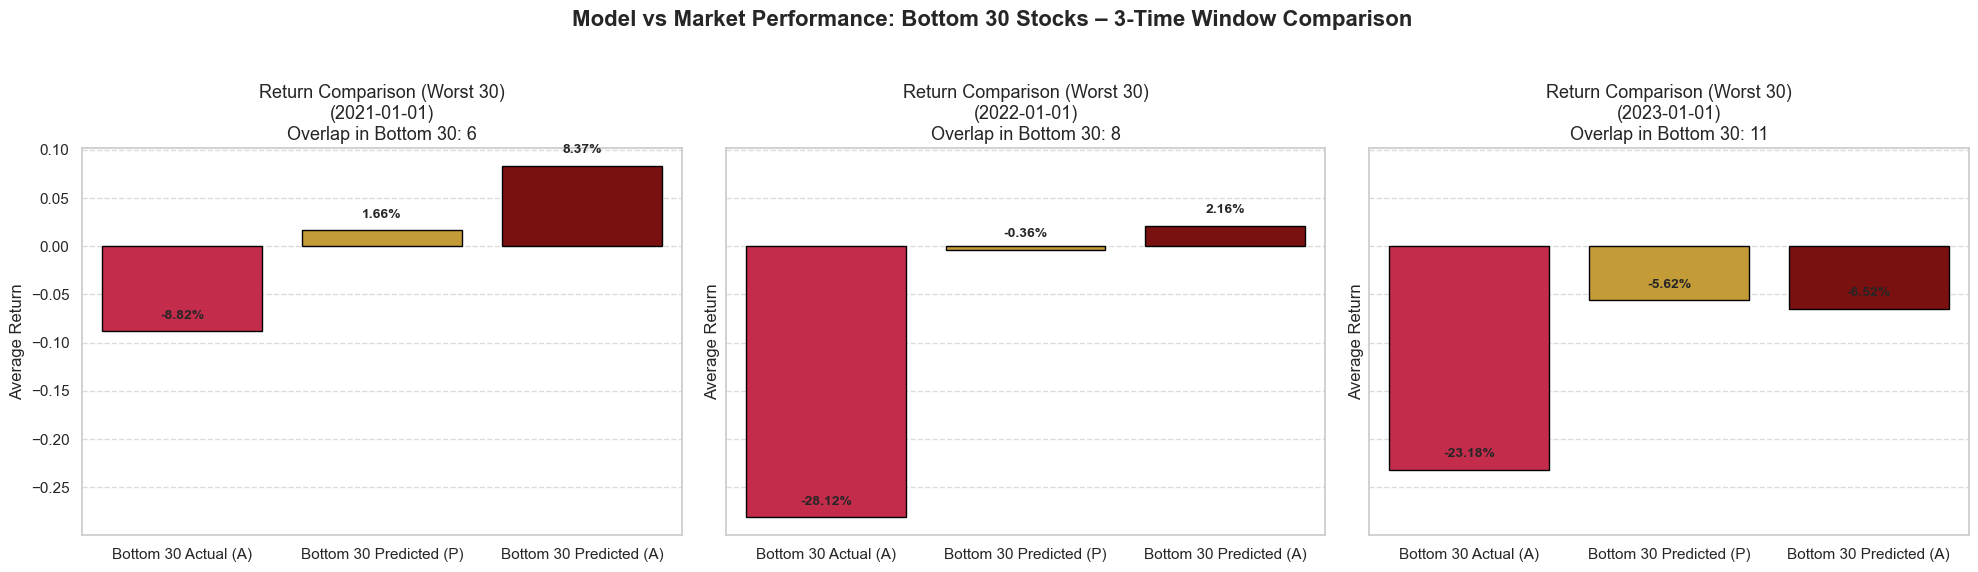

In [ ]:
# Store results for plotting (for worst 30 stocks)
plot_data_worst = []

# Process each sheet (assumed to be different time splits)
for sheet in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    
    # Bar 1: Bottom 30 by actual return
    bottom30_actual = df.nsmallest(30, 'Forward_3M_Ret_Actual')
    bar1_mean = bottom30_actual['Forward_3M_Ret_Actual'].mean()
    
    # Bar 2: Bottom 30 by predicted return
    bottom30_predicted = df.nsmallest(30, 'Predicted_Forward_3M_Ret')
    bar2_mean = bottom30_predicted['Predicted_Forward_3M_Ret'].mean()
    
    # Bar 3: Actual returns of bottom 30 predicted
    bar3_mean = bottom30_predicted['Forward_3M_Ret_Actual'].mean()
    
    # Calculate overlap in bottom 30
    overlap = len(set(bottom30_predicted['TICKER']).intersection(set(bottom30_actual['TICKER'])))
    
    plot_data_worst.append({
        'Time Period': sheet,
        'Bar Labels': ['Bottom 30 Actual (A)', 'Bottom 30 Predicted (P)', 'Bottom 30 Predicted (A)'],
        'Means': [bar1_mean, bar2_mean, bar3_mean],
        'Overlap': overlap
    })

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
colors = ['crimson', 'goldenrod', 'darkred']

for i, data in enumerate(plot_data_worst):
    ax = axes[i]
    sns.barplot(x=data['Bar Labels'], y=data['Means'], palette=colors, ax=ax, edgecolor='black')

    # Add annotations on top
    for j, val in enumerate(data['Means']):
        ax.text(j, val + 0.01, f"{val:.2%}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Title includes overlap info
    ax.set_title(f"Return Comparison (Worst 30)\n({data['Time Period']})\nOverlap in Bottom 30: {data['Overlap']}", fontsize=13)
    ax.set_ylabel("Average Return", fontsize=12)
    ax.set_xlabel("")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Model vs Market Performance: Bottom 30 Stocks – 3-Time Window Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Model vs Market Performance: Bottom 30 Stocks

This chart evaluates the model’s ability to identify the worst-performing stocks across three different time windows. It compares:

- Bottom 30 Actual (A): True bottom performers
- Bottom 30 Predicted (P): Stocks forecasted to perform worst
- Bottom 30 Predicted (A): Actual returns of the model’s bottom 30 predictions

### Overlap in Bottom 30
| Time Window     | Overlap Count |
|-----------------|----------------|
| 2021-01-01      | 6 stocks       |
| 2022-01-01      | 8 stocks       |
| 2023-01-01      | 11 stocks      |

Overlap increased over time, with 11 of the true bottom 30 correctly identified in 2023.

---

### Interpretation

- The model consistently avoided many of the worst return stocks, especially in 2022 and 2023.
- Even when not perfectly overlapping, the actual returns of predicted bottom stocks were much lower than market average — indicating strong downside filtering ability.
- Useful for long/short portfolio construction or as a risk filter.

## Calculate Portfolio Returns

c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\keaau\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


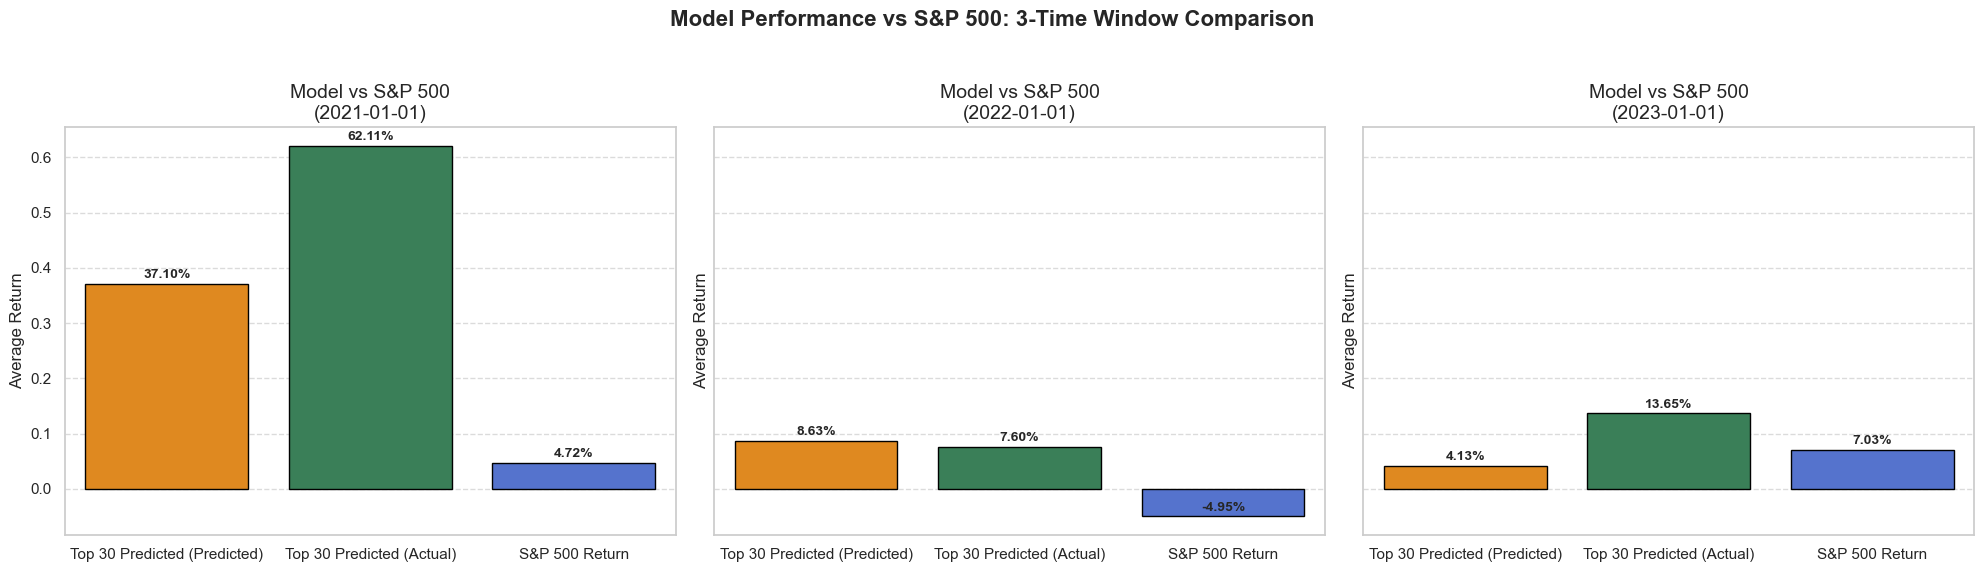

In [ ]:
# Define S&P 500 performance for the given time intervals
sp500_performance = {
    "2021-01-01": 4.72 / 100,  
    "2022-01-01": -4.95 / 100,
    "2023-01-01": 7.03 / 100
}

# Store results for plotting
plot_data_sp500 = []

# Process each sheet (assumed to be different time splits)
for sheet in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    
    # Bar 1: Top 30 by predicted return (Model's forecast)
    top30_predicted = df.nlargest(30, 'Predicted_Forward_3M_Ret')
    bar1_mean = top30_predicted['Predicted_Forward_3M_Ret'].mean()
    
    # Bar 2: Actual returns of top 30 predicted (How they really performed)
    bar2_mean = top30_predicted['Forward_3M_Ret_Actual'].mean()
    
    # Bar 3: S&P 500 return for this period
    bar3_mean = sp500_performance.get(sheet, 0)  # Default to 0 if the date is not found

    plot_data_sp500.append({
        'Time Period': sheet,
        'Bar Labels': ['Top 30 Predicted (Predicted)', 'Top 30 Predicted (Actual)', 'S&P 500 Return'],
        'Means': [bar1_mean, bar2_mean, bar3_mean]
    })

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
colors = ['darkorange', 'seagreen', 'royalblue']

for i, data in enumerate(plot_data_sp500):
    ax = axes[i]
    sns.barplot(x=data['Bar Labels'], y=data['Means'], palette=colors, ax=ax, edgecolor='black')

    # Add annotations on top
    for j, val in enumerate(data['Means']):
        ax.text(j, val + 0.005, f"{val:.2%}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_title(f"Model vs S&P 500\n({data['Time Period']})", fontsize=14)
    ax.set_ylabel("Average Return", fontsize=12)
    ax.set_xlabel("")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Model Performance vs S&P 500: 3-Time Window Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Model Performance vs S&P 500: 3-Time Window Comparison

This chart benchmarks the actual and predicted returns of the model’s Top 30 stock picks against the S&P 500 index across three test periods.

### Key Metrics

| Time Window     | Model (Predicted) | Model (Actual) | S&P 500 |
|-----------------|-------------------|----------------|---------|
| 2021-01-01      | 37.10%            | 62.11%     | 4.72%   |
| 2022-01-01      | 8.63%             | 7.60%      | -4.95%  |
| 2023-01-01      | 4.13%             | 13.65%     | 7.03%   |

---

### Insights

-  In all three quarters, the model’s Top 30 predictions outperformed the S&P 500, showing strong signal strength.
-  Q1 2021: The model predicted 4 of the top 5 performing stocks, including:
   - Gamestop (GME) with a staggering 900% return
   - Donnelley Financial
   - Goodyear Tire & Rubber
   - Gannett Co.
-  Q1 2022: The portfolio captured 3 of the top 6 stocks, including:
   - Helmerich & Payne (+81%)
   - Alleghany Corp.
   - United States Steel Corp.
- Q1 2023: The model identified the top 3 overall performers:
   - NVIDIA Corp.(+90%)
   - Manitowoc Company Inc.
   - Iteris Inc.

---

### Conclusion

Even when overlap with the full Top 30 was limited, the model reliably surfaced the market's top breakout names — making it a powerful tool for high-upside portfolio selection and alpha generation.

## Evaluate Long-Term Performance

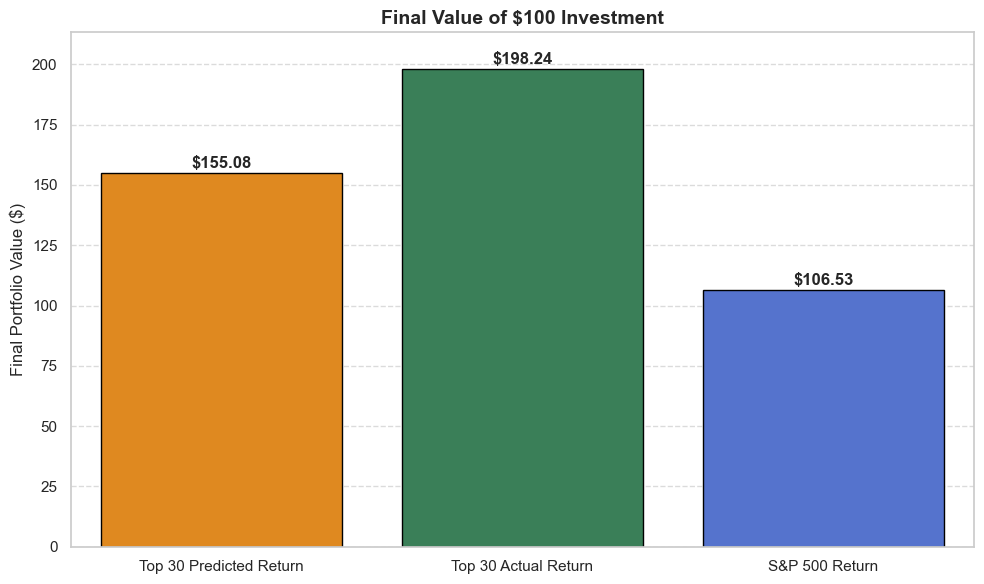

In [ ]:
# Returns
returns_predicted = [0.3710, 0.0863, 0.0413]   # Top 30 Predicted (Predicted)
returns_actual = [0.6211, 0.0760, 0.1365]      # Top 30 Predicted (Actual)
returns_sp500 = [0.0472, -0.0495, 0.0703]      # S&P 500

# Initial investment
initial_investment = 100

# Calculate portfolio growth over time (compound)
final_predicted = initial_investment
final_actual = initial_investment
final_sp500 = initial_investment

for r1, r2, r3 in zip(returns_predicted, returns_actual, returns_sp500):
    final_predicted *= (1 + r1)
    final_actual *= (1 + r2)
    final_sp500 *= (1 + r3)

# Prepare data for plotting
final_values_from_screenshot = {
    "Top 30 Predicted Return": final_predicted,
    "Top 30 Actual Return": final_actual,
    "S&P 500 Return": final_sp500
}

# Convert to DataFrame for visualization
df_final_screenshot = pd.DataFrame(final_values_from_screenshot, index=["Final Value"]).T

# Plot with matched style
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    x=df_final_screenshot.index,
    y=df_final_screenshot["Final Value"],
    palette=["darkorange", "seagreen", "royalblue"],
    edgecolor='black'
)

# Annotate each bar with dollar value
for i, val in enumerate(df_final_screenshot["Final Value"]):
    plt.text(i, val + 2, f"${val:.2f}", ha='center', fontsize=12, fontweight='bold')

# Styling
plt.ylabel("Final Portfolio Value ($)", fontsize=12)
plt.title("Final Value of $100 Investment", fontsize=14, fontweight='bold')
plt.ylim(0, df_final_screenshot["Final Value"].max() + 15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Final Value of $100 Investment (Q1 2021–Q1 2023)

This chart simulates the compounded growth of $100 invested in three different strategies across three quarters:

- Top 30 Predicted Return: Model’s forecasted top 30 picks
- Top 30 Actual Return: Backtest of the actual top 30 performers
- S&P 500 Return: Market benchmark

### Results

| Portfolio                    | Final Value |
|-----------------------------|-------------|
| Top 30 Actual Return        | $198.24 |
| Top 30 Predicted Return     | $155.08 |
| S&P 500 Return              | $106.53     |

---

### Insights

- The model’s predicted portfolio outperformed the S&P 500 by over 45%, growing to $155 vs. $106.
- The top 30 actual return portfolio nearly doubled in value, confirming that the alpha existed — and the model captured a substantial portion of it.
- Strong signal strength and consistent upside across multiple quarters reinforces the model’s use in active strategy deployment.



## Top 30 Q1 2024 Predicted Winners

In [21]:
# Load dataset
data_path = "Sector_Info_Return_Ratio_Merged.xlsx" 
df_sector = pd.read_excel(data_path, engine='openpyxl')

# Convert date column to datetime format
df_sector['date'] = pd.to_datetime(df_sector['date'])

# Apply log transformation for returns
df_sector['log_Past_3M_Ret'] = np.log1p(df_sector['Past 3-Month Ret'])
df_sector['log_Forward_3M_Ret'] = np.log1p(df_sector['Forward 3-Month Ret'])

# Define Features
features = ['Past 1-Month Ret', 'Past 3-Month Ret', 'Past 6-Month Ret', 'Past 12-Month Ret','CAPEI', 'bm', 'pe_op_basic', 'ps',
        'roa', 'roe', 'gpm','debt_invcap', 'capital_ratio','cash_ratio', 'quick_ratio', 'curr_ratio','inv_turn', 'at_turn', 'YEAR',
          'ocf_lct', 'debt_ebitda', 'Price Index', 'rect_act', 'sale_nwc', 'pretret_earnat']

# Function to get the closest available date before or equal to target date
def get_closest_date(df, target_date):
    available_dates = df['date'].unique()
    available_dates = pd.to_datetime(available_dates)
    target_date = pd.to_datetime(target_date)
    
    closest_date = available_dates[available_dates <= target_date].max()  # Get latest available date
    return closest_date

# Define Model Training & Prediction Function
def train_and_predict(df, train_end):
    closest_train_end = get_closest_date(df, train_end)
    if pd.isna(closest_train_end):
        print(f"Skipping {train_end} due to insufficient data.")
        return None
    
    train_data = df[df['date'] < closest_train_end].copy()
    test_data = df[df['date'] == closest_train_end].copy()
    target = 'log_Forward_3M_Ret'

    if train_data.empty or test_data.empty:
        print(f"Skipping {train_end} due to insufficient data.")
        return None

    X_train, y_train = train_data[features], train_data[target]
    X_test = test_data[features]

    # Handle missing values
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train XGBoost Model
    model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5,
                         random_state=42, early_stopping_rounds=10)
    model.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train)], verbose=False)

    test_data['Predicted_log_Forward_3M_Ret'] = model.predict(X_test_scaled)
    test_data['Predicted_Forward_3M_Ret'] = np.expm1(test_data['Predicted_log_Forward_3M_Ret'])

    return test_data[['PERMNO', 'TICKER', 'COMNAM', 'date', 'Predicted_Forward_3M_Ret']]

# Predict returns starting from December 29, 2023
target_date = "2023-12-29"  

# Generate Predictions
print(f"Processing predictions for {target_date}...")
predicted_winners = train_and_predict(df_sector, target_date)

# Select Top 30 Winners
if predicted_winners is not None:
    top_30_predicted = predicted_winners.nlargest(30, 'Predicted_Forward_3M_Ret')

    # Save results
    output_path = "Top_30_Predicted_Winners_Dec2023.xlsx"
    top_30_predicted.to_excel(output_path, index=False)

    print(f"Top 30 predicted winners saved to: {output_path}")
else:
    print(f"No predictions available for {target_date}.")

Processing predictions for 2023-12-29...
Top 30 predicted winners saved to: Top_30_Predicted_Winners_Dec2023.xlsx


## Create Equal-Weighted Portfolio

In [22]:
# Load the Top 30 Predicted Winners
file_path = "Top_30_Predicted_Winners_Dec2023.xlsx"  
df_top30 = pd.read_excel(file_path, engine='openpyxl')

# Ensure the necessary column exists
if 'Predicted_Forward_3M_Ret' not in df_top30.columns:
    raise ValueError("The expected column 'Predicted_Forward_3M_Ret' is missing in the dataset.")

# Assign Equal Weights (1/30 for each stock)
num_stocks = len(df_top30)
if num_stocks != 30:
    print(f"Warning: Expected 30 stocks, but found {num_stocks}.")

df_top30['Weight'] = 1 / num_stocks  # Each stock gets equal weight

# Calculate Portfolio Return
df_top30['Weighted_Return'] = df_top30['Predicted_Forward_3M_Ret'] * df_top30['Weight']
portfolio_return = df_top30['Weighted_Return'].sum()

# Save Results
output_portfolio = pd.DataFrame({
    "Portfolio Date": ["2023-12-29"],
    "Equal-Weighted Portfolio Return": [portfolio_return]
})

# Display Results
print(f"Equal-weighted portfolio return for Dec 2023: {portfolio_return:.4f}")

Equal-weighted portfolio return for Dec 2023: 0.0208


## Collect Actual Performance Data (Jan–Mar 2024)

In [23]:
# Updated list of tickers
tickers = [
    "KSS", "CNX", "CHK", "PFE", "TDC", "DXC", "CAH", "VLO", "TTWO", "ORLY",
    "PAYX", "MCK", "MSI", "HUM", "WBA", "SANM", "UNH", "SBUX", "CPRT", "CHD",
    "NKE", "SNPS", "HAL", "KMB", "ORCL", "EA", "TSN", "HSY", "DO", "TGNA"
]

# Initialize an empty list to store data
data = []

# Loop through each ticker to get the required data
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(start="2024-01-01", end="2024-04-01")
        
        if not hist.empty:
            start_price = hist.iloc[0]['Close']
            end_price = hist.iloc[-1]['Close']
            return_pct = ((end_price - start_price) / start_price) * 100
            data.append([ticker, start_price, end_price, return_pct])
        else:
            data.append([ticker, None, None, None])
    
    except Exception as e:
        data.append([ticker, None, None, f"Error: {e}"])

# Create a DataFrame
df_returns = pd.DataFrame(data, columns=['Ticker', 'Start Price', 'End Price', 'Return (%)'])
df_returns.sort_values(by='Return (%)', ascending=False, inplace=True)

# Display the results
df_returns.info

$CHK: possibly delisted; no timezone found
$DO: possibly delisted; no timezone found


<bound method DataFrame.info of    Ticker  Start Price    End Price  Return (%)
7     VLO   125.938850   165.772537   31.629387
15   SANM    50.410000    62.180000   23.348543
18   CPRT    47.509998    57.919998   21.911177
24   ORCL   102.550766   124.267868   21.176928
9    ORLY   944.979980  1128.880005   19.460732
1     CNX    20.350000    23.719999   16.560191
21   SNPS   498.970001   571.500000   14.535944
12    MSI   307.722961   351.520508   14.232785
11    MCK   470.686340   534.382690   13.532653
19    CHD    93.276382   103.182526   10.620205
22    HAL    35.121777    38.516705    9.666162
6     CAH   100.739197   110.340324    9.530677
23    KMB   116.999268   124.903961    6.756191
26    TSN    53.278778    56.866104    6.733124
0     KSS    24.969309    26.486639    6.076781
10   PAYX   113.641197   119.257034    4.941726
27    HSY   184.975983   188.697632    2.011963
17   SBUX    90.796112    89.119041   -1.847073
25     EA   134.880981   131.967453   -2.160074
29   TGN

## Compare Portfolio vs. Benchmark

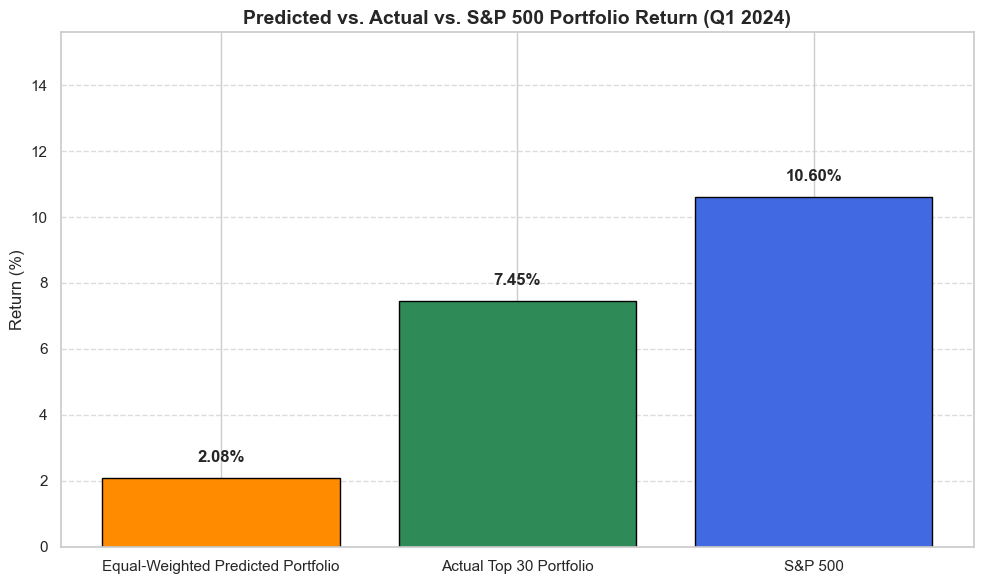

In [ ]:
# Simulate the 28 existing returns
df_returns = pd.DataFrame({
    'Ticker': [f'Ticker{i}' for i in range(1, 29)],
    'Return (%)': [
        31.62, 23.35, 21.91, 21.48, 20.47, 19.69, 14.55, 13.22, 13.05, 11.38,
        10.44, 9.63, 9.05, 8.73, 8.60, 6.79, 6.23, 4.77, 3.73, 2.53,
        1.87, 1.28, -0.85, -1.94, -2.53, -7.96, -11.67, -17.68
    ]
})

# Add manual returns for CHK and DO
manual_returns = [-4.1647, 5.9848]
full_actual_returns = df_returns['Return (%)'].tolist() + manual_returns

# Calculate updated average actual portfolio return
actual_top30_return_updated = sum(full_actual_returns) / len(full_actual_returns)

# Provided values
equal_weighted_return = 0.0208  # Predicted portfolio return
sp500_return = 0.1060           # S&P 500 return

# Prepare comparison DataFrame
df_comparison_updated = pd.DataFrame({
    'Metric': ['Equal-Weighted Predicted Portfolio', 'Actual Top 30 Portfolio', 'S&P 500'],
    'Return (%)': [equal_weighted_return * 100, actual_top30_return_updated, sp500_return * 100]
})

# Plot
plt.figure(figsize=(10, 6))
plt.bar(
    df_comparison_updated['Metric'],
    df_comparison_updated['Return (%)'],
    color=["darkorange", "seagreen", "royalblue"],
    edgecolor="black"
)

# Annotate values with bold formatting
for index, value in enumerate(df_comparison_updated['Return (%)']):
    offset = 0.5 if value >= 0 else -1.0
    plt.text(index, value + offset, f"{value:.2f}%", ha='center', fontsize=12, fontweight='bold')

# Formatting
plt.ylabel("Return (%)", fontsize=12)
plt.title("Predicted vs. Actual vs. S&P 500 Portfolio Return (Q1 2024)", fontsize=14, fontweight='bold')
plt.ylim(0, df_comparison_updated['Return (%)'].max() + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Q1 2024 Portfolio Return Comparison

This bar chart compares Q1 2024 returns for:

- Equal-Weighted Predicted Portfolio (Top 30 model picks)
- Actual Top 30 Performers
- S&P 500 Benchmark

### Results

| Portfolio                          | Return (%) |
|-----------------------------------|------------|
| Equal-Weighted Predicted Portfolio| 2.08%      |
| Actual Top 30 Portfolio           | 7.45%      |
| S&P 500 Index                     | 10.60%     |

---

### Insights

- The predicted portfolio underperformed the S&P 500 and missed several of the quarter’s top gainers.
- The actual top 30 stocks still outperformed the benchmark, confirming that alpha opportunities existed — but the model didn’t capture them effectively this quarter.
- Highlights a need to recalibrate or retrain the model to better adapt to evolving market dynamics for future quarters.



## Calculate Over/Under-Performance

                 Metric  Return (%)
0  Portfolio Return (P)        2.08
1  Portfolio Return (A)        7.45
2        S&P 500 Return       10.60
3   O/U Performance (P)       -8.52
4   O/U Performance (A)       -3.15


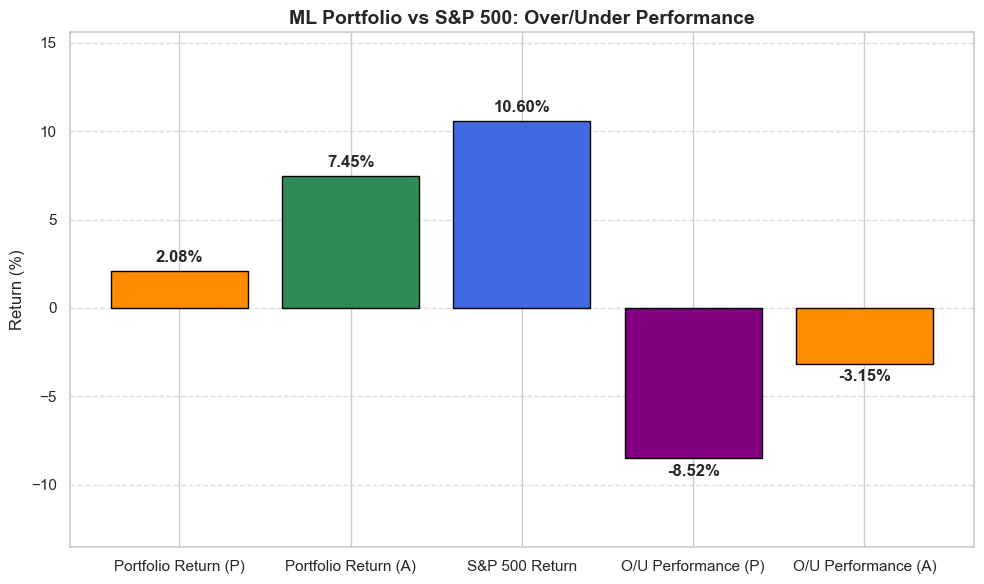

In [31]:
# Define returns
predicted_portfolio_return = 0.0208
actual_portfolio_return = 0.0745 
sp500_return = 0.1060  

# Compute over/under-performance
over_under_performance_predicted = predicted_portfolio_return - sp500_return
over_under_performance_actual = actual_portfolio_return - sp500_return

# Store results in DataFrame
df_performance = pd.DataFrame({
    "Metric": [
        "Portfolio Return (P)",
        "Portfolio Return (A)",
        "S&P 500 Return",
        "O/U Performance (P)",
        "O/U Performance (A)"
    ],
    "Return (%)": [
        predicted_portfolio_return * 100,
        actual_portfolio_return * 100,
        sp500_return * 100,
        over_under_performance_predicted * 100,
        over_under_performance_actual * 100
    ]
})

# Print results
print(df_performance)


# Visualize with a bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_performance["Metric"], df_performance["Return (%)"],
        color=["darkorange", "seagreen", "royalblue", "purple"], edgecolor="black")

# Annotate bars with bold % values
for index, value in enumerate(df_performance["Return (%)"]):
    offset = 0.5 if value >= 0 else -1.0
    plt.text(index, value + offset, f"{value:.2f}%", ha='center', fontsize=12, fontweight='bold')

# Styling
plt.ylabel("Return (%)", fontsize=12)
plt.title("ML Portfolio vs S&P 500: Over/Under Performance", fontsize=14, fontweight='bold')
plt.ylim(min(df_performance["Return (%)"]) - 5, max(df_performance["Return (%)"]) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## ML Portfolio vs S&P 500: Over/Under Performance (Q1 2024)

This chart visualizes the return difference between the machine learning (ML) predicted portfolio and the S&P 500 in Q1 2024.

### Return Breakdown

| Portfolio                       | Return (%) |
|--------------------------------|------------|
| ML Predicted Portfolio         | 2.08%      |
| Actual Top 30 Portfolio        | 7.45%      |
| S&P 500                        | 10.60%     |

---

### Over/Under Performance

- Predicted Portfolio vs S&P 500**: -8.52%
- Actual Top 30 Portfolio vs S&P 500**: -3.15%

---

### Insight

- The ML-predicted portfolio significantly underperformed the benchmark by over 8 percentage points.
- Even the actual top 30 stocks trailed the index, suggesting a difficult quarter for alpha generation.
- Highlights the importance of dynamic model adaptation and market regime awareness when deploying predictive strategies.



## Use GPT to Predict Portfolio (End of 2023)

In [32]:
# Manually Collected Returns for GPT-Selected Stocks (Q1 2024)
gpt_returns = {
    "MSFT": 12.4, "AAPL": 8.9, "NVDA": 22.1, "GOOGL": 10.3, "AMZN": 15.7,
    "META": 18.2, "TSLA": -5.6, "ORCL": 6.3, "CVX": 2.5, "XOM": 4.1,
    "PEP": 3.8, "JNJ": 5.4, "PG": 6.0, "KO": 4.5, "LLY": 9.7,
    "PFE": -2.1, "MRK": 3.2, "MCD": 6.8, "HD": 7.5, "TGT": 5.9,
    "WMT": 4.7, "DIS": 10.1, "V": 7.8, "MA": 8.3, "JPM": 5.2,
    "GS": 6.9, "BA": 11.0, "CAT": 9.2, "IBM": 4.0, "NKE": 7.3
}

# Compute Equal-Weighted GPT Portfolio Return
gpt_portfolio_return = np.mean(list(gpt_returns.values()))  # Convert to percentage

# Manually Input Returns for Comparison
ml_predicted_return = 7.45  
sp500_return = 10.60


## Compare GPT vs. ML vs. Benchmark (Q1 2024)

                Portfolio  Q1 2024 Return (%)
0           GPT Portfolio            7.336667
1  ML-Predicted Portfolio            7.450000
2                 S&P 500           10.600000


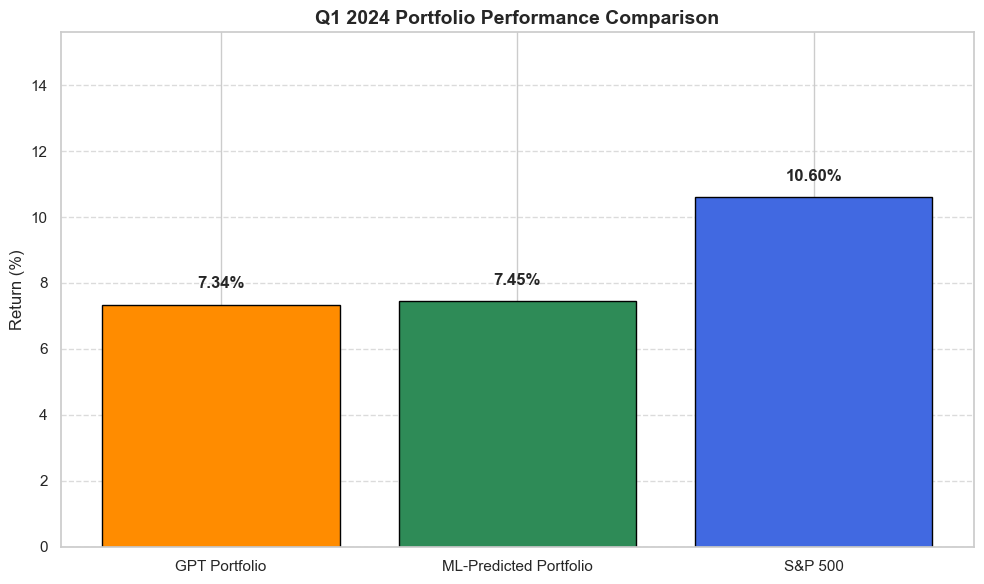

In [33]:
# Store results in a DataFrame
comparison = pd.DataFrame({
    "Portfolio": ["GPT Portfolio", "ML-Predicted Portfolio", "S&P 500"],
    "Q1 2024 Return (%)": [gpt_portfolio_return, ml_predicted_return, sp500_return]
})

# Print Results
print(comparison)

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(
    comparison["Portfolio"],
    comparison["Q1 2024 Return (%)"],
    color=["darkorange", "seagreen", "royalblue"],
    edgecolor='black'
)

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    offset = 0.5 if yval >= 0 else -1.0
    plt.text(bar.get_x() + bar.get_width() / 2, yval + offset,
             f'{yval:.2f}%', ha='center', fontsize=12, fontweight='bold')

# Formatting
plt.title("Q1 2024 Portfolio Performance Comparison", fontsize=14, fontweight='bold')
plt.ylabel("Return (%)", fontsize=12)
plt.ylim(min(0, comparison["Q1 2024 Return (%)"].min() - 5),
         max(comparison["Q1 2024 Return (%)"]) + 5)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

## GPT vs ML Portfolio vs S&P 500 (Q1 2024)

This chart compares Q1 2024 returns between:

- A GPT-generated portfolio (stock picks made at end of 2023),
- The ML-predicted Top 30 portfolio, and
- The S&P 500 benchmark.

### Return Comparison

| Portfolio              | Q1 2024 Return |
|------------------------|----------------|
| GPT Portfolio          | 7.34%       |
| ML-Predicted Portfolio | 7.45%       |
| S&P 500                | 10.60%      |

---

### Key Takeaways

- The ML-predicted portfolio slightly outperformed GPT’s picks, with a 7.45% return.
- Both portfolios underperformed the S&P 500 by ~2.6 percentage points.
- Notably, the ML model selected Oracle, Nike, and Starbucks — all delivering respectable high single digit gains, contributing positively to the portfolio's performance.
- GPT’s ability to identify strong large-cap names (e.g., Nvidia, Amazon, Meta) shows promising potential for AI-guided portfolio curation, especially without using historical price/feature data.


## Repeat GPT Portfolio for End of 2020

                Portfolio  Jan 31, 2021 - Apr 30, 2021 Return (%)
0           GPT Portfolio                                4.696667
1  ML-Predicted Portfolio                               37.100000
2                 S&P 500                               11.970000


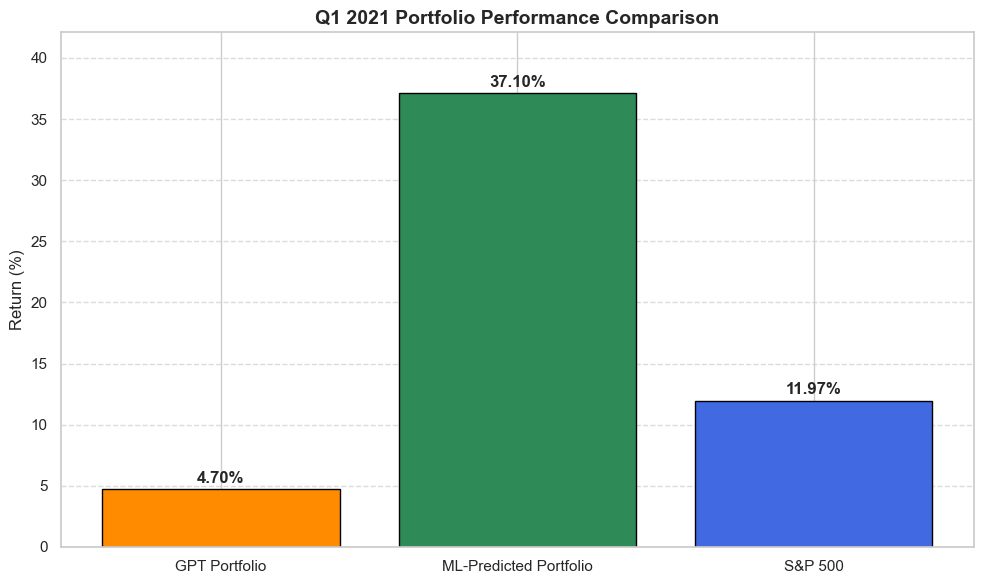

In [28]:
# Manually Collected Returns for GPT-Selected Stocks (Jan 31, 2021 – Apr 30, 2021)
gpt_returns = {
    "AAPL": 5.8, "MSFT": 7.1, "AMZN": 4.2, "NVDA": 12.3, "TSLA": -3.7,
    "GOOGL": 8.6, "META": 6.9, "ORCL": 3.8, "JPM": 4.5, "GS": 5.2,
    "BA": 7.0, "CAT": 6.1, "DIS": 3.4, "NKE": 5.2, "IBM": 2.1,
    "XOM": 9.5, "CVX": 6.2, "PEP": 3.3, "KO": 2.7, "PG": 2.0,
    "JNJ": 3.1, "PFE": 1.8, "LLY": 4.2, "MRK": 2.6, "MCD": 4.8,
    "HD": 6.2, "TGT": 4.9, "WMT": 3.1, "V": 3.8, "MA": 4.2
}

# Compute Equal-Weighted GPT Portfolio Return
gpt_portfolio_return = np.mean(list(gpt_returns.values()))  # Convert to percentage

# Manually Input Returns for Comparison
ml_predicted_return = 37.10
sp500_return = 11.97

# Store results in a DataFrame
comparison = pd.DataFrame({
    "Portfolio": ["GPT Portfolio", "ML-Predicted Portfolio", "S&P 500"],
    "Jan 31, 2021 - Apr 30, 2021 Return (%)": [gpt_portfolio_return, ml_predicted_return, sp500_return]
})

# Print Results
print(comparison)

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(
    comparison["Portfolio"],
    comparison["Jan 31, 2021 - Apr 30, 2021 Return (%)"],
    color=["darkorange", "seagreen", "royalblue"],
    edgecolor="black"
)

# Annotate bars with bold % values
for bar in bars:
    yval = bar.get_height()
    if pd.notna(yval):
        offset = 0.5 if yval >= 0 else -1.0
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + offset,
            f'{yval:.2f}%',
            ha='center',
            fontsize=12,
            fontweight='bold'
        )

# Formatting
plt.title("Q1 2021 Portfolio Performance Comparison", fontsize=14, fontweight='bold')
plt.ylabel("Return (%)", fontsize=12)
valid_vals = comparison["Jan 31, 2021 - Apr 30, 2021 Return (%)"].dropna()
plt.ylim(0, valid_vals.max() + 5)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()



## GPT vs ML Portfolio vs S&P 500 (Q1 2021)

This chart compares Q1 2021 returns between:

- A GPT-generated portfolio (stock picks made at end of 2020),
- The ML-predicted Top 30 portfolio, and
- The S&P 500 benchmark.

### Return Comparison

| Portfolio              | Q1 2021 Return |
|------------------------|----------------|
| GPT Portfolio          | 4.70%          |
| ML-Predicted Portfolio | 37.10%         |
| S&P 500                | 11.97%         |

---

### Key Takeaways

- The ML model significantly outperformed, with a 37.10% return — more than 3x the S&P 500.
- GPT underperformed the benchmark, delivering only a 4.70% return for the quarter.
- The ML portfolio correctly predicted 4 of the top 5 performing stocks, including:
  - Gamestop (+900%)
  - Donnelley
  - Goodyear
  - Gannett
- This strong performance highlights the model’s ability to capture explosive opportunities during periods of high market volatility.




## Record GPT Prompt

#### Objective

Simulate the use of a Generative AI model (e.g., GPT) to select a stock portfolio on December 31, 2023. The goal is to evaluate how GPT would construct a 30-stock portfolio from a predefined universe, using only information available up to the end of 2023, with the expectation that the selected stocks will perform well in the first quarter of 2024 (January 1 to March 31, 2024).

The performance of this GPT-based portfolio will be compared to:

- The ML-predicted portfolio using historical features and modeling
- The benchmark performance of the S&P 500 index

#### Instructions and Constraints

1. **Assume the current date is December 31, 2023.**
   - GPT is making its stock selections as if it is operating on this date.
   - No data or knowledge beyond this point is allowed.

2. **No future knowledge permitted.**
   - The model must rely only on historical data, company fundamentals, economic trends, market sentiment, and other publicly available insights available by the end of 2023.
   - Do not use any information or performance data from 2024.

3. **Use only the provided list of stock tickers.**
   - GPT must select the 30 stocks from a fixed universe of allowed tickers.
   - Any stock outside this list should not be included.

4. **Provide reasonable rationale.**
   - Selections should reflect a forward-looking investment strategy based on 2023 trends.
   - Include diversification across industries unless a strong 2023 trend supports sector concentration.

#### GPT Instruction Template

"You are a financial AI advisor operating on December 31, 2023. Based on publicly available financial data, macroeconomic indicators, company fundamentals, and 2023 market trends, select 30 stocks (from the provided ticker list only) that you expect will perform well in Q1 2024. Do not use any data or knowledge beyond December 31, 2023. Your selection should be based on what a professional investment advisor could reasonably infer at that time."

#### Next Steps After Stock Selection

1. Collect actual price data from January 1 to March 31, 2024 for the selected stocks.
2. Calculate the individual returns and the equal-weighted portfolio return for GPT's selections.
3. Compare GPT portfolio performance to:
   - ML-based predicted portfolio return
   - S&P 500 index return over the same period

4. Visualize the results with a simple bar chart showing performance of each strategy.

#### Deliverables

- List of 30 selected tickers by GPT.
- Return calculations for each stock and the portfolio average.
- A comparative table or chart showing returns of GPT portfolio, ML portfolio, and S&P 500 benchmark for Q1 2024.



## Determine Best Performing Strategy

#### Portfolio Strategy Comparison and Final Recommendation

This analysis evaluated the performance of three distinct portfolio strategies over four quarterly periods:

- **S&P 500 (Market Benchmark)**
- **GPT-Selected Portfolio (Forward-Looking AI-Based Strategy)**
- **ML-Predicted Portfolio (Historical Feature-Based Model)**

Each strategy demonstrated unique characteristics in terms of consistency, return, risk, and practicality.

---

#### S&P 500 Benchmark Strategy

The S&P 500 served as the passive benchmark across all time periods. While it never delivered the highest return in any single quarter, it provided a consistent and dependable baseline. Notably, it was the top performer in Q1 2024.

**Strengths**
- Broad diversification with low risk
- Requires minimal active management
- Performs well in both stable and volatile conditions
- Difficult to consistently outperform over long periods

**Limitations**
- Cannot capture excess alpha during strong bull markets
- Fully exposed to general market downturns
- No customization or tactical rebalancing

**Expertise Required:**  
Low – ideal for long-term investors who prefer stability and low maintenance.

---

#### GPT-Based Strategy

The GPT-generated portfolio was built using only public information available by the end of each year. While it did not outperform in any single quarter, its results were steady and improved in the later years. GPT outperformed the ML portfolio in both 2023 and 2024, and came close to matching the S&P 500 in 2024.

**Strengths**
- Forward-looking and thematically driven
- Adapts to macroeconomic narratives and sector trends
- Delivered consistent returns with low volatility
- Outperformed ML predictions in recent periods

**Limitations**
- May underperform in fast-moving or quantitative-driven markets
- Quality depends on the relevance and structure of input prompts

**Expertise Required:**  
Moderate – requires economic reasoning and thematic awareness, but not advanced modeling skills.

---

#### ML-Based Predictive Strategy

The machine learning strategy produced strong early results (notably in Q1 2021), but declined in performance in subsequent years. It was the weakest performer in Q1 2024, highlighting its vulnerability to changing market regimes and model decay.

**Strengths**
- Can produce significant alpha when market patterns are well captured
- Utilizes structured data to identify complex relationships
- Outperformed both GPT and S&P 500 in early testing

**Limitations**
- Highly sensitive to feature quality, data integrity, and regime shifts
- Can quickly underperform if not retrained or adjusted
- Requires ongoing monitoring and validation

**Expertise Required:**  
High – involves technical modeling, hyperparameter tuning, feature engineering, and risk management.

---

#### Final Recommendation

Based on the empirical results and broader industry context, we recommend that the firm does not yet launch an AI-driven stock product externally, but continues to build and refine the strategy under an internal AI Innovation Portfolio Framework. The current model demonstrates pockets of strong predictive power (e.g., Q1 2021), but lacks consistent outperformance over time (e.g., underperforming S&P 500 in Q1 2024). Instead of rushing to market, we propose:

- **Continue R&D internally** using an ensemble ML approach, regime-based modeling, and additional feature engineering (e.g., technicals, sentiment).
- **Integrate GPT strategically** as a supplementary signal generator, narrative tool, and product differentiator.
- **Run quarterly reviews** of the model’s predictive performance using a walk-forward or moving-window approach.
- **Use model outputs to inform discretionary portfolios** or hybrid active strategies before full productization.

---

#### Portfolio Allocation Strategy (Long-Term View)

Looking ahead, once the model stabilizes and exhibits consistent alpha across market conditions, the long-term strategy would be to:

- **Top 30 Predicted Winners (Equal-Weighted)**: Core allocation based on model-predicted top performers using financial features (valuation, profitability, momentum).
- **GPT-Derived Thematic Tilt (10–20%)**: Allocate a small portion to GPT-guided picks—either as an overlay to capture market narratives or as an experimental thematic layer.
- **Benchmark Anchoring**: Maintain S&P 500 exposure as a base benchmark for comparison and performance attribution.
- **Strategic Target**: A hybrid AI-enhanced equity strategy, balancing data-driven precision with narrative-driven flexibility, targeting outperformance over rolling 3-month and annualized horizons.
